### 지표 3개로 최적화

In [ ]:
# 76.5초

import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Set

@dataclass
class WarehouseParameters:
    picking_time: float
    walking_time: float
    cart_capacity: int
    rack_capacity: int
    number_pickers: int

class WarehouseSolver:
    def __init__(self, orders: pd.DataFrame, parameters: pd.DataFrame, od_matrix: pd.DataFrame):
        self.orders = orders.copy()
        self.params = self._load_parameters(parameters)
        self.od_matrix = od_matrix
        self.start_location = od_matrix.index[0]
        self.end_location = od_matrix.index[1]
        
        self._initialize_orders()
        self._validate_input()

    def _load_parameters(self, parameters: pd.DataFrame) -> WarehouseParameters:
        get_param = lambda x: parameters.loc[parameters['PARAMETERS'] == x, 'VALUE'].iloc[0]
        return WarehouseParameters(
            picking_time=float(get_param('PT')),
            walking_time=float(get_param('WT')),
            cart_capacity=int(get_param('CAPA')),
            rack_capacity=int(get_param('RK')),
            number_pickers=int(get_param('PK'))
        )

    def _initialize_orders(self) -> None:
        self.orders['LOC'] = pd.NA
        self.orders['LOC'] = self.orders['LOC'].astype(str)
        self.orders['CART_NO'] = pd.NA
        self.orders['SEQ'] = pd.NA

    def _validate_input(self) -> None:
        if self.orders.empty or self.od_matrix.empty:
            raise ValueError("Input data or OD matrix is empty")
        required_columns = {'ORD_NO', 'SKU_CD'}
        if not required_columns.issubset(self.orders.columns):
            raise ValueError(f"Missing required columns: {required_columns - set(self.orders.columns)}")

    def solve_storage_location(self) -> None:
        """
        Solve Storage Location Assignment Problem (SLAP)
        1단계: 고빈도 SKU 80개 → 입출고지점에 가까운 랙
        2단계: 고빈도 SKU와 자주 주문되는 SKU 80개 → 고빈도 SKU 랙 근처(closeness 기준)
        3단계: 두 개 이상 SKU 주문건 중 자주 등장하는 SKU 80개 → betweeness 기준
        4단계: 나머지 SKU들 → 주문 빈도순 + closeness 기준
        """

        # 초기 변수 설정
        rack_locations = list(self.od_matrix.index[2:])  # oWP_Start, oWP_End 제외
        sku_freq = self.orders['SKU_CD'].value_counts()  # SKU 빈도
        used_racks = set()
        assigned_skus = {}
        rack_capacity = self.params.rack_capacity
        total_racks = len(rack_locations)

        # 1단계: 고빈도 SKU 80개 → 입출고지점 가까운 랙
        high_freq_skus = sku_freq.head(80).index.tolist()

        # 입출고지점과 가까운 랙 순 (closeness 기준)
        from networkx import Graph
        import networkx as nx

        G = nx.from_pandas_adjacency(self.od_matrix.astype(float))
        closeness = nx.closeness_centrality(G, distance='weight')
        sorted_racks = sorted([r for r in rack_locations], key=lambda x: -closeness[x])  # 가까운 순 (값이 클수록 중심)

        rack_iter = iter(sorted_racks)
        for i in range(0, 80, rack_capacity):
            rack = next(rack_iter)
            assigned_skus[rack] = high_freq_skus[i:i + rack_capacity]
            used_racks.add(rack)

        # 2단계: 고빈도 SKU와 함께 주문된 SKU 80개 (고빈도 SKU 제외)
        from collections import Counter
        co_occur = Counter()

        for ord_no, group in self.orders.groupby('ORD_NO'):
            skus = group['SKU_CD'].tolist()
            if any(sku in high_freq_skus for sku in skus):
                for sku in skus:
                    if sku not in high_freq_skus:
                        co_occur[sku] += 1

        related_skus = [sku for sku, _ in co_occur.most_common() if sku not in high_freq_skus][:80]

        # 고빈도 SKU가 배치된 랙 기준으로 closeness 높은 랙에 배치
        rack_left = [r for r in rack_locations if r not in used_racks]
        related_rack_scores = []
        for r in rack_left:
            # 가까운 고빈도 랙과의 거리 합 기준
            score = sum(nx.shortest_path_length(G, source=r, target=hr, weight='weight')
                        for hr in used_racks if nx.has_path(G, r, hr))
            related_rack_scores.append((r, score))

        sorted_related_racks = [r for r, _ in sorted(related_rack_scores, key=lambda x: x[1])]
        rack_iter = iter(sorted_related_racks)

        for i in range(0, len(related_skus), rack_capacity):
            rack = next(rack_iter)
            assigned_skus[rack] = related_skus[i:i + rack_capacity]
            used_racks.add(rack)

        # 3단계: 2개 이상 SKU 주문 건에서 자주 등장하는 SKU 80개 → betweeness 기준
        pair_orders = self.orders.groupby('ORD_NO').filter(lambda x: len(x) > 1)
        pair_sku_freq = pair_orders['SKU_CD'].value_counts()
        middle_skus = [sku for sku in pair_sku_freq.index
                      if sku not in high_freq_skus and sku not in related_skus][:80]

        betweenness = nx.betweenness_centrality(G, weight='weight')
        betweenness_racks = sorted([r for r in rack_locations if r not in used_racks],
                                    key=lambda x: -betweenness[x])
        rack_iter = iter(betweenness_racks)

        for i in range(0, len(middle_skus), rack_capacity):
            rack = next(rack_iter)
            assigned_skus[rack] = middle_skus[i:i + rack_capacity]
            used_racks.add(rack)

        # 4단계: 나머지 SKU들 → 주문 빈도순 + 남은 랙의 closeness 기준
        remaining_skus = [sku for sku in sku_freq.index
                          if sku not in high_freq_skus and sku not in related_skus and sku not in middle_skus]

        closeness_racks = sorted([r for r in rack_locations if r not in used_racks],
                                  key=lambda x: -closeness[x])
        rack_iter = iter(closeness_racks)

        for i in range(0, len(remaining_skus), rack_capacity):
            try:
                rack = next(rack_iter)
                assigned_skus[rack] = remaining_skus[i:i + rack_capacity]
            except StopIteration:
                break  # 랙이 더 이상 없을 경우

        # SKU -> LOC 매핑
        sku_to_location = {}
        for rack, skus in assigned_skus.items():
            for sku in skus:
                sku_to_location[sku] = rack

        self.orders['LOC'] = self.orders['SKU_CD'].map(sku_to_location)

    def solve_order_batching(self) -> None:
        """Solve Order Batching and Sequencing Problem (OBSP) using FIFO strategy"""
        unique_orders = sorted(self.orders['ORD_NO'].unique())
        num_carts = len(unique_orders) // self.params.cart_capacity + 1
        
        order_to_cart = {}
        for cart_no in range(1, num_carts + 1):
            start_idx = (cart_no - 1) * self.params.cart_capacity
            end_idx = start_idx + self.params.cart_capacity
            cart_orders = unique_orders[start_idx:end_idx]
            for order in cart_orders:
                order_to_cart[order] = cart_no

        self.orders['CART_NO'] = self.orders['ORD_NO'].map(order_to_cart)

    def solve_picker_routing(self) -> None:
        """Solve Pick Routing Problem (PRP) using simple sequencing"""
        self.orders = self.orders.sort_values(['CART_NO', 'LOC'])
        self.orders['SEQ'] = self.orders.groupby('CART_NO').cumcount() + 1

    def solve(self) -> pd.DataFrame:
        """Execute complete warehouse optimization solution"""
        self.solve_storage_location()
        self.solve_order_batching()
        self.solve_picker_routing()
        return self.orders

def main(INPUT: pd.DataFrame, PARAMETER: pd.DataFrame, OD_MATRIX: pd.DataFrame) -> pd.DataFrame:
    solver = WarehouseSolver(INPUT, PARAMETER, OD_MATRIX)
    return solver.solve()

if __name__ == "__main__":
    try:
        test_INPUT = pd.read_csv("./data/Sample_InputData.csv")
        test_PARAM = pd.read_csv("./data/Sample_Parameters.csv")
        test_OD = pd.read_csv("./data/Sample_OD_Matrix.csv", index_col=0, header=0)

        print("Data loaded successfully:")
        print(f"- Orders: {test_INPUT.shape}")
        print(f"- Parameters: {test_PARAM.shape}")
        print(f"- OD Matrix: {test_OD.shape}")

        result = main(test_INPUT, test_PARAM, test_OD)
        result.to_csv("Sample_OutputData.csv", index=False)
        print("\nOptimization completed. Results preview:")
        print(result.head())

    except FileNotFoundError as e:
        print(f"Error: Unable to load required files - {str(e)}")
    except (pd.errors.DataError, pd.errors.EmptyDataError) as e:
        print(f"Error: Data validation failed - {str(e)}")
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
        
        
# 76초도 시간 초과

Data loaded successfully:
- Orders: (1426, 6)
- Parameters: (5, 3)
- OD Matrix: (170, 170)

Optimization completed. Results preview:
      ORD_NO    SKU_CD  NUM_PCS      LOC  CART_NO  SEQ
4   ORD_0002  SKU_0123        1  WP_0006        1    1
7   ORD_0003  SKU_0057        1  WP_0010        1    2
5   ORD_0002  SKU_0005        1  WP_0011        1    3
0   ORD_0001  SKU_0267        1  WP_0020        1    4
12  ORD_0004  SKU_0037        1  WP_0043        1    5


> 중심성 한 번 계산 & nx.계산 안쓰고 matrix 활용

In [ ]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Set
import networkx as nx

@dataclass
class WarehouseParameters:
    picking_time: float
    walking_time: float
    cart_capacity: int
    rack_capacity: int
    number_pickers: int

class WarehouseSolver:
    def __init__(self, orders: pd.DataFrame, parameters: pd.DataFrame, od_matrix: pd.DataFrame):
        self.orders = orders.copy()
        self.params = self._load_parameters(parameters)
        self.od_matrix = od_matrix
        self.start_location = od_matrix.index[0]
        self.end_location = od_matrix.index[1]

        self._initialize_orders()
        self._validate_input()

    def _load_parameters(self, parameters: pd.DataFrame) -> WarehouseParameters:
        get_param = lambda x: parameters.loc[parameters['PARAMETERS'] == x, 'VALUE'].iloc[0]
        return WarehouseParameters(
            picking_time=float(get_param('PT')),
            walking_time=float(get_param('WT')),
            cart_capacity=int(get_param('CAPA')),
            rack_capacity=int(get_param('RK')),
            number_pickers=int(get_param('PK'))
        )

    def _initialize_orders(self) -> None:
        self.orders['LOC'] = pd.NA
        self.orders['LOC'] = self.orders['LOC'].astype(str)
        self.orders['CART_NO'] = pd.NA
        self.orders['SEQ'] = pd.NA

    def _validate_input(self) -> None:
        if self.orders.empty or self.od_matrix.empty:
            raise ValueError("Input data or OD matrix is empty")
        required_columns = {'ORD_NO', 'SKU_CD'}
        if not required_columns.issubset(self.orders.columns):
            raise ValueError(f"Missing required columns: {required_columns - set(self.orders.columns)}")

    def solve_storage_location(self) -> None:
        """
        Solve Storage Location Assignment Problem (SLAP)
        1단계: 고빈도 SKU 80개 → 입출고지점에 가까운 랙
        2단계: 고빈도 SKU와 자주 주문되는 SKU 80개 → 고빈도 SKU 랙 근처(closeness 기준)
        3단계: 두 개 이상 SKU 주문건 중 자주 등장하는 SKU 80개 → betweeness 기준
        4단계: 나머지 SKU들 → 주문 빈도순 + closeness 기준
        """

        # 초기 변수 설정
        rack_locations = list(self.od_matrix.index[2:])  # oWP_Start, oWP_End 제외
        sku_freq = self.orders['SKU_CD'].value_counts()  # SKU 빈도
        used_racks = set()
        assigned_skus = {}
        rack_capacity = self.params.rack_capacity
        total_racks = len(rack_locations)

        # 1단계: 고빈도 SKU 80개 → 입출고지점 가까운 랙
        high_freq_skus = sku_freq.head(80).index.tolist()

        # 입출고지점과 가까운 랙 순 (closeness 기준)
        G = nx.from_pandas_adjacency(self.od_matrix.astype(float))
        # 중심성 계산 한 번만 하도록 캐싱  
        if not hasattr(self, '_closeness'):
            self._closeness = nx.closeness_centrality(G, distance='weight')
        closeness = self._closeness
        sorted_racks = sorted([r for r in rack_locations], key=lambda x: -closeness[x])  # 가까운 순 (값이 클수록 중심)

        rack_iter = iter(sorted_racks)
        for i in range(0, 80, rack_capacity):
            rack = next(rack_iter)
            assigned_skus[rack] = high_freq_skus[i:i + rack_capacity]
            used_racks.add(rack)

        # 2단계: 고빈도 SKU와 함께 주문된 SKU 80개 (고빈도 SKU 제외)
        from collections import Counter
        co_occur = Counter()

        for ord_no, group in self.orders.groupby('ORD_NO'):
            skus = group['SKU_CD'].tolist()
            if any(sku in high_freq_skus for sku in skus):
                for sku in skus:
                    if sku not in high_freq_skus:
                        co_occur[sku] += 1

        related_skus = [sku for sku, _ in co_occur.most_common() if sku not in high_freq_skus][:80]

        # 고빈도 SKU가 배치된 랙 기준으로 closeness 높은 랙에 배치
        rack_left = [r for r in rack_locations if r not in used_racks]
        related_rack_scores = []
        for r in rack_left:
            # 가까운 고빈도 랙과의 거리 합 기준
            # shortest_path_length 대신 OD Matrix 직접 사용(nx.shortest_path_length(G, ,,)) 
            score = sum(self.od_matrix.loc[r, hr] for hr in used_racks if hr in self.od_matrix.columns)
            related_rack_scores.append((r, score))

        sorted_related_racks = [r for r, _ in sorted(related_rack_scores, key=lambda x: x[1])]
        rack_iter = iter(sorted_related_racks)

        for i in range(0, len(related_skus), rack_capacity):
            rack = next(rack_iter)
            assigned_skus[rack] = related_skus[i:i + rack_capacity]
            used_racks.add(rack)

        # 3단계: 2개 이상 SKU 주문 건에서 자주 등장하는 SKU 80개 → betweeness 기준
        pair_orders = self.orders.groupby('ORD_NO').filter(lambda x: len(x) > 1)
        pair_sku_freq = pair_orders['SKU_CD'].value_counts()
        middle_skus = [sku for sku in pair_sku_freq.index
                      if sku not in high_freq_skus and sku not in related_skus][:80]

        if not hasattr(self, '_betweenness'):
            self._betweenness = nx.betweenness_centrality(G, weight='weight')
        betweenness = self._betweenness

        betweenness_racks = sorted([r for r in rack_locations if r not in used_racks],
                                    key=lambda x: -betweenness[x])
        rack_iter = iter(betweenness_racks)

        for i in range(0, len(middle_skus), rack_capacity):
            rack = next(rack_iter)
            assigned_skus[rack] = middle_skus[i:i + rack_capacity]
            used_racks.add(rack)

        # 4단계: 나머지 SKU들 → 주문 빈도순 + 남은 랙의 closeness 기준
        remaining_skus = [sku for sku in sku_freq.index
                          if sku not in high_freq_skus and sku not in related_skus and sku not in middle_skus]

        closeness_racks = sorted([r for r in rack_locations if r not in used_racks],
                                  key=lambda x: -closeness[x])
        rack_iter = iter(closeness_racks)

        for i in range(0, len(remaining_skus), rack_capacity):
            try:
                rack = next(rack_iter)
                assigned_skus[rack] = remaining_skus[i:i + rack_capacity]
            except StopIteration:
                break  # 랙이 더 이상 없을 경우

        # SKU -> LOC 매핑
        sku_to_location = {}
        for rack, skus in assigned_skus.items():
            for sku in skus:
                sku_to_location[sku] = rack

        self.orders['LOC'] = self.orders['SKU_CD'].map(sku_to_location)

    def solve_order_batching(self) -> None:
        """Solve Order Batching and Sequencing Problem (OBSP) using FIFO strategy"""
        unique_orders = sorted(self.orders['ORD_NO'].unique())
        num_carts = len(unique_orders) // self.params.cart_capacity + 1

        order_to_cart = {}
        for cart_no in range(1, num_carts + 1):
            start_idx = (cart_no - 1) * self.params.cart_capacity
            end_idx = start_idx + self.params.cart_capacity
            cart_orders = unique_orders[start_idx:end_idx]
            for order in cart_orders:
                order_to_cart[order] = cart_no

        self.orders['CART_NO'] = self.orders['ORD_NO'].map(order_to_cart)

    def solve_picker_routing(self) -> None:
        """Solve Pick Routing Problem (PRP) using simple sequencing"""
        self.orders = self.orders.sort_values(['CART_NO', 'LOC'])
        self.orders['SEQ'] = self.orders.groupby('CART_NO').cumcount() + 1

    def solve(self) -> pd.DataFrame:
        """Execute complete warehouse optimization solution"""
        self.solve_storage_location()
        self.solve_order_batching()
        self.solve_picker_routing()
        return self.orders

def main(INPUT: pd.DataFrame, PARAMETER: pd.DataFrame, OD_MATRIX: pd.DataFrame) -> pd.DataFrame:
    solver = WarehouseSolver(INPUT, PARAMETER, OD_MATRIX)
    return solver.solve()

if __name__ == "__main__":
    try:
        test_INPUT = pd.read_csv("./data/Sample_InputData.csv")
        test_PARAM = pd.read_csv("./data/Sample_Parameters.csv")
        test_OD = pd.read_csv("./data/Sample_OD_Matrix.csv", index_col=0, header=0)

        print("Data loaded successfully:")
        print(f"- Orders: {test_INPUT.shape}")
        print(f"- Parameters: {test_PARAM.shape}")
        print(f"- OD Matrix: {test_OD.shape}")

        result = main(test_INPUT, test_PARAM, test_OD)
        result.to_csv("Sample_OutputData.csv", index=False)
        print("\nOptimization completed. Results preview:")
        print(result.head())

    except FileNotFoundError as e:
        print(f"Error: Unable to load required files - {str(e)}")
    except (pd.errors.DataError, pd.errors.EmptyDataError) as e:
        print(f"Error: Data validation failed - {str(e)}")
    except Exception as e:
        print(f"Unexpected error: {str(e)}")

# 13.8초


Data loaded successfully:
- Orders: (1426, 6)
- Parameters: (5, 3)
- OD Matrix: (170, 170)

Optimization completed. Results preview:
      ORD_NO    SKU_CD  NUM_PCS      LOC  CART_NO  SEQ
4   ORD_0002  SKU_0123        1  WP_0006        1    1
7   ORD_0003  SKU_0057        1  WP_0010        1    2
5   ORD_0002  SKU_0005        1  WP_0011        1    3
0   ORD_0001  SKU_0267        1  WP_0023        1    4
12  ORD_0004  SKU_0037        1  WP_0043        1    5


### MIP 방식

In [ ]:
# !pip install pulp

> STEP1 : 단독 주문 VS 합산 주문 클러스터링
- 단독 주문되는 SKU 중 주문 빈도가 높은 SKU 상위 20%를 입출고 지점과 가까운 곳에 배치

> STEP 2 : 주문 유사도 클러스터링(클러스터링에 SKU 1개만 포함되도 OK)
- 주문 빈도가 높은 SKU를 포함하고 있는 클러스터부터 순서대로 MIT함수를 적용하여 배치

In [ ]:
import pandas as pd
import numpy as np

df_orders = pd.read_csv('./data/Sample_InputData.csv')
df_orders.head()

df_od_matrix = pd.read_csv('./data/Sample_OD_Matrix.csv', index_col= 0)
df_od_matrix.head()


entrance= df_od_matrix.index[0]
entrance

unique_skus = df_orders['SKU_CD'].unique()

sku_freq = df_orders['SKU_CD'].value_counts()
sku_freq.head()

sku_by_ordno = df_orders.groupby('ORD_NO')['SKU_CD'].apply(list).to_dict()
sku_by_ordno['ORD_0002'] # dict {ord_no : sku_lst}

# sku 유형 분리
# 단독 주문 SKU / 동시 주문 SKU

from collections import defaultdict

sku_total_orders = defaultdict(set)
sku_single_orders = defaultdict(set)

for ord_no, sku_list in sku_by_ordno.items() :
  for sku in sku_list :
    sku_total_orders[sku].add(ord_no) # sku별 총 주문 수
  
  if len(sku_list) == 1 : # 단독 주문인 경우
    sku = sku_list[0]
    sku_single_orders[sku].add(ord_no)

sku_single_ratio = {}
for sku in unique_skus :
  total = len(sku_total_orders[sku])
  single = len(sku_single_orders[sku])
  ratio = single/total if total > 0 else 0
  sku_single_orders[sku] = ratio

threshold = 0.8 # 80:20
single_skus = [sku for sku, r in sku_single_ratio.items() if r >= threshold]
multi_skus = [sku for sku in unique_skus if sku not in single_skus]

len(single_skus)
len(multi_skus)

if len(single_skus) > 0 :
  n_top= int(0.2 * len(single_skus))
  top_single_skus = sku_freq.loc[single_skus].sort_values(ascending= False).head(n_top).index.tolist()

# 입출고 지점으로부터 거리순 랙 정렬
entrance_dist = df_od_matrix.loc[entrance].sort_values()
rack_priority = entrance_dist.index.tolist()

sku_to_location = {}
for s, r in zip(top_single_skus, rack_priority) :
  sku_by_ordno[s] = r


'oWP_Start'

In [33]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# SKU x ORD_NO 행렬
sku_ord_df = df_orders.pivot_table(index='SKU_CD', columns='ORD_NO', aggfunc='size', fill_value=0)

# 차원 축소
scaled = StandardScaler().fit_transform(sku_ord_df)
pca = PCA(n_components=2)
sku_pca = pca.fit_transform(scaled)

# 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(sku_pca)

sku_cluster = pd.Series(clusters, index=sku_ord_df.index)

c:\Users\chjin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


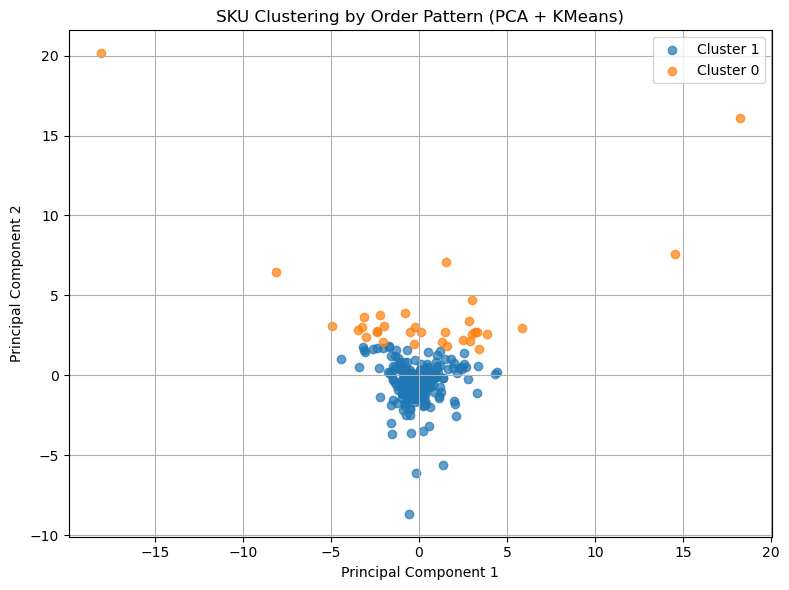

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# PCA 결과와 클러스터 번호를 하나의 DataFrame으로 통합
sku_cluster_df = pd.DataFrame(sku_pca, columns=['PC1', 'PC2'])
sku_cluster_df['SKU_CD'] = sku_ord_df.index
sku_cluster_df['Cluster'] = sku_cluster.values

# 시각화
plt.figure(figsize=(8,6))
for label in sku_cluster_df['Cluster'].unique():
    subset = sku_cluster_df[sku_cluster_df['Cluster'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {label}', alpha=0.7)

plt.title('SKU Clustering by Order Pattern (PCA + KMeans)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
from collections import defaultdict
import pandas as pd

# 1. 주문번호별 SKU 리스트 (중복 제거)
sku_by_ordno = df_orders.groupby('ORD_NO')['SKU_CD'].apply(lambda x: list(set(x))).to_dict()

# 2. SKU별 등장 주문 수 / 단독 등장 주문 수
sku_total_orders = defaultdict(set)
sku_single_orders = defaultdict(set)

for ord_no, sku_list in sku_by_ordno.items():
    for sku in sku_list:
        sku_total_orders[sku].add(ord_no)
    if len(sku_list) == 1:
        sku = sku_list[0]
        sku_single_orders[sku].add(ord_no)

# 3. SKU별 단독 비율 계산
sku_single_ratio = {
    sku: len(sku_single_orders[sku]) / len(sku_total_orders[sku])
    if len(sku_total_orders[sku]) > 0 else 0
    for sku in df_orders['SKU_CD'].unique()
}

# 4. 단독 비율 + 클러스터 결합
df_single_ratio = pd.DataFrame({
    'SKU_CD': list(sku_single_ratio.keys()),
    'Single_Ratio': list(sku_single_ratio.values())
})
df_single_ratio['Cluster'] = df_single_ratio['SKU_CD'].map(sku_cluster)

# 5. 클러스터별 평균 단독 주문 비율 계산
cluster_avg_ratio = df_single_ratio.groupby('Cluster')['Single_Ratio'].mean()

# 6. 결과 출력
print(cluster_avg_ratio)

Cluster
0    0.047763
1    0.100684
Name: Single_Ratio, dtype: float64


In [41]:
# sku_by_ordno['ORD_0002']

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from scipy.sparse import csr_matrix

# SKU x ORD matrix
sku_ord_df = df_orders.pivot_table(index='SKU_CD', columns='ORD_NO', aggfunc='size', fill_value=0)
sku_ord_df.head()

# 같은 주문에 자주 함께 등장한 sku일수록 유사도가 높아짐
# sku_similarity = cosine_similarity(sku_ord_df)

# 유사도 기반 클러스터링 (유사도 없으면 각 SKU가 단독 클러스터 가능)
# distance_threshold : 병합을 중지할 거리 기준(이 값보다 더 먼 거리의 노드는 병합하지 않음)
# metric : 거리 측정 방법 / 유클리디안,맨하튼,코사인,프리컴퓨티드(거리 행렬 직접 넘겨주는 경우)
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.0, metric='cosine', linkage='complete')
clusters = clustering.fit_predict(sku_ord_df)

# SKU → 클러스터 매핑
sku_cluster = pd.Series(clusters, index=sku_ord_df.index)
sku_cluster

SKU_CD
SKU_0001     32
SKU_0002     50
SKU_0003     27
SKU_0004     34
SKU_0005     53
           ... 
SKU_0332     96
SKU_0333     83
SKU_0334     40
SKU_0335     60
SKU_0336    128
Length: 336, dtype: int64

In [49]:
sku_freq

SKU_CD
SKU_0117    10
SKU_0253     9
SKU_0255     9
SKU_0053     9
SKU_0307     9
            ..
SKU_0086     1
SKU_0249     1
SKU_0327     1
SKU_0212     1
SKU_0022     1
Name: count, Length: 336, dtype: int64

In [52]:
cluster_freq = sku_freq.groupby(sku_cluster).sum().sort_values(ascending=False)
cluster_freq 
# 클러스터 0에는 SKU001, SKU002가 포함되어 있고,
# SKU001은 21번, SKU002는 10번 주문되었으니 → 클러스터 0의 총 주문 수 = 31

sorted_clusters = cluster_freq.index.tolist()
# sorted_clusters
# 주문량 많은 cluster 순서대로 정렬

In [61]:
from pulp import LpProblem, LpVariable, LpMinimize, LpBinary, lpSum

def optimize_cluster_milp(cluster_id, sku_list, available_racks, df_od_matrix, entrance, rack_capacity=2):
    prob = LpProblem(f"Cluster_{cluster_id}_Assignment", LpMinimize)

    # 결정 변수: x[s, r] = SKU s가 랙 r에 배정되면 1
    x = LpVariable.dicts("x", [(s, r) for s in sku_list for r in available_racks], cat=LpBinary)

    # 보조 변수: z[(s1, s2, r1, r2)] = 1 if s1→r1 and s2→r2
    z = LpVariable.dicts("z", [
        (s1, s2, r1, r2)
        for i, s1 in enumerate(sku_list)
        for j, s2 in enumerate(sku_list)
        if i < j
        for r1 in available_racks
        for r2 in available_racks
    ], cat=LpBinary)

    # 목적함수: 입구~SKU 거리 + SKU 간 랙 거리
    prob += lpSum(
        df_od_matrix.loc[entrance, r] * x[(s, r)]
        for s in sku_list for r in available_racks
    ) + lpSum(
        df_od_matrix.loc[r1, r2] * z[(s1, s2, r1, r2)]
        for i, s1 in enumerate(sku_list)
        for j, s2 in enumerate(sku_list)
        if i < j
        for r1 in available_racks
        for r2 in available_racks
    )

    # 제약조건 1: 각 SKU는 하나의 랙에만 배정
    for s in sku_list:
        prob += lpSum(x[(s, r)] for r in available_racks) == 1

    # 제약조건 2: 각 랙에는 최대 rack_capacity 개의 SKU만 배정 가능
    for r in available_racks:
        prob += lpSum(x[(s, r)] for s in sku_list) <= rack_capacity

    # 제약조건 3: 보조 변수 선형화 (AND 연산: z = x1 AND x2)
    for i, s1 in enumerate(sku_list):
        for j, s2 in enumerate(sku_list):
            if i < j:
                for r1 in available_racks:
                    for r2 in available_racks:
                        z_var = z[(s1, s2, r1, r2)]
                        prob += z_var <= x[(s1, r1)]
                        prob += z_var <= x[(s2, r2)]
                        prob += z_var >= x[(s1, r1)] + x[(s2, r2)] - 1

    # 최적화 수행
    prob.solve()

    # 결과 반환
    best_assignment = {}
    for s in sku_list:
        for r in available_racks:
            if x[(s, r)].varValue == 1:
                best_assignment[s] = r
                break

    return best_assignment

In [ ]:
available_racks = list(df_od_matrix.index[2:])  # oWP_Start, oWP_End 제외


for cluster_id in sorted_clusters:
    sku_list = sku_cluster[sku_cluster == cluster_id].index.tolist()
    best_map = optimize_cluster_milp(cluster_id, sku_list, available_racks, df_od_matrix, entrance)
    sku_to_location.update(best_map)
    available_racks = list(set(available_racks) - set(best_map.values()))
    

In [37]:
!pip freeze > temp_requirements.txt